## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

## Loading the data

In [3]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

def explore_data(data):
    print(data.head().T)
    print(data.describe())
    print(data.info())

## Visualizing the data

In [4]:
def plot_histograms(data):
    data.hist(bins=15, figsize=(20, 20))
    plt.show()

def plot_correlation_matrix(data):
    temp_df = data.copy()
    temp_df = pd.get_dummies(temp_df, columns=['Disease'])
    plt.figure(figsize=(24, 16))
    sns.heatmap(temp_df.corr(), fmt='.2f', annot=True, cmap='coolwarm', annot_kws={"size": 7})
    plt.show()

## Preprocessing and Feature Engineering

In [5]:
def pfe(data):
    disease_encoded_df = pd.get_dummies(data['Disease'], prefix='Disease')
    data = pd.concat([data, disease_encoded_df], axis=1)
    data.drop('Disease', axis=1, inplace=True)
    
    data.drop('Diseasegroup', axis=1, inplace=True)
    
    categorical_features = ['RecipientABO', 'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV',
                     'Antigen', 'Allele', 'extcGvHD']
    numerical_features = ['CD3dCD34', 'CD3dkgx10d8', 'Rbodymass']
    imputer_cat = SimpleImputer(strategy='most_frequent')
    imputer_num = SimpleImputer(strategy='median')
    data[categorical_features] = imputer_cat.fit_transform(data[categorical_features])
    data[numerical_features] = imputer_num.fit_transform(data[numerical_features])
    
    error_rules = {
        'Recipientgender': lambda x: x in [0, 1],  # 0: Femenino, 1: Masculino
        'Stemcellsource': lambda x: x in [0, 1],  # 0: Sangre periférica, 1: Médula ósea
        'Donorage': lambda x: (0 <= x <= 120),  # Edad del donante fuera del rango
        'Donorage35': lambda x: x in [0, 1],  # Edad del donante fuera del rango
        'IIIV': lambda x: x in [0, 1],  # Clasificación del trasplante entre I y IV
        'Gendermatch': lambda x: x in [0, 1],  # 0: No compatible, 1: Compatible
        'DonorABO': lambda x: x in [-1, 0, 1, 2],  # -1: B, 0: O, 1: A, 2: AB
        'RecipientABO': lambda x: x in [-1, 0, 1, 2],  # -1: B, 0: O, 1: A, 2: AB
        'RecipientRh': lambda x: x in [0, 1],  # 0: Rh-, 1: Rh+
        'ABOmatch': lambda x: x in [0, 1],  # 0: Mismatched, 1: Matched
        'CMVstatus': lambda x: x in [0, 1, 2, 3],  # Presencia/ausencia de CMV y otros estados
        'DonorCMV': lambda x: x in [0, 1],  # 0: Negativo, 1: Positivo
        'RecipientCMV': lambda x: x in [0, 1],  # 0: Negativo, 1: Positivo
        #'Disease': lambda x: x in ['ALL', 'AML', 'chronic', 'nonmalignant', 'lymphoma'],  # Tipos de enfermedad
        'Riskgroup': lambda x: x in [0, 1],  # 0: Bajo, 1: Alto
        'Txpostrelapse': lambda x: x in [0, 1],  # 0: No, 1: Sí (trasplante tras recaída)
        #'Diseasegroup': lambda x: x in [0, 1],  # 0: No maligna, 1: Maligna
        'HLAmatch': lambda x: x in [0, 1, 2, 3],  # Compatibilidad HLA 7/10 a 10/10
        'HLAmismatch': lambda x: x in [0, 1],  # 0: Compatible, 1: No compatible
        'Antigen': lambda x: x in [-1, 0, 1, 2],  # Diferencia de antígenos entre donante y receptor
        'Allele': lambda x: x in [-1, 0, 1, 2, 3],  # Diferencia de alelos entre donante y receptor
        'HLAgrI': lambda x: (0 <= x <= 5),  # Grado de diferencia HLA (fuera de rango)
        'Recipientage': lambda x: (0 <= x <= 120),  # Edad del receptor fuera de rango
        'Recipientage10': lambda x: x in [0, 1],  # 0: >= 10 años, 1: < 10 años
        'Recipientageint': lambda x: x in [0, 1, 2],  # Edad del receptor discretizada en intervalos
        'Relapse': lambda x: x in [0, 1],  # 0: No, 1: Sí (recaída)
        'aGvHDIIIIV': lambda x: x in [0, 1, 2, 3],  # Grado de GvHD aguda entre 0 y IV
        'extcGvHD': lambda x: x in [0, 1],  # 0: No, 1: Sí (GvHD crónica extensa)
        'CD34kgx10d6': lambda x: (0 <= x <= 60),  # Dosis de CD34+ fuera de rango
        'CD3dCD34': lambda x: (0 <= x <= 100),  # Relación CD3/CD34 fuera de rango
        'CD3dkgx10d8': lambda x: (0 <= x <= 21),  # Dosis de CD3+ fuera de rango
        'Rbodymass': lambda x: (6 <= x <= 104),  # Masa corporal del receptor fuera de rango
        'ANCrecovery': lambda x: (7 <= x <= 30),  # Tiempo de recuperación de neutrófilos fuera de rango
        'PLTrecovery': lambda x: (0 <= x <= 365),  # Tiempo de recuperación de plaquetas fuera de rango
        'time_to_aGvHD_III_IV': lambda x: (0 <= x <= 365),  # Tiempo en días hasta GvHD aguda
        'survival_time': lambda x: (0 <= x <= 4000),  # Tiempo de supervivencia fuera de rango
        'survival_status': lambda x: x in [0, 1],  # 0: Vivo, 1: Fallecido
    }
    wrong_variables = set()
    for col, rule in error_rules.items():
        errors = data[~data[col].apply(rule)]
        num_errors = len(errors)
        if num_errors > 0:
            print(f'Variable: {col}, Wrong values detected: {num_errors}')
            if col != 'time_to_aGvHD_III_IV':
                wrong_variables.update(errors.index.tolist())
    data.drop('time_to_aGvHD_III_IV', axis=1, inplace=True)
    data.drop(index=wrong_variables, inplace=True)
    
    log_columns = ['Rbodymass', 'CD34kgx10d6', 'CD3dkgx10d8', 'CD3dCD34', 'ANCrecovery', 'PLTrecovery']
    sqrt_columns = ['survival_time']
    for col in log_columns:
            data[col] = np.log1p(data[col])
    for col in sqrt_columns:
            data[col] = np.sqrt(data[col])
        
    standard_columns = ['Donorage', 'Recipientage', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8',  'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'survival_time']
    scaler = StandardScaler()
    data[standard_columns] = scaler.fit_transform(data[standard_columns])
    
    outliers_columns = ['CD3dCD34', 'ANCrecovery', 'PLTrecovery']
    for col in outliers_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        data[col] = data[col].apply(
            lambda x: x if lower_bound <= x <= upper_bound else np.nan
        )

    return data

## Splitting the dataset

In [6]:
def split_data(data, target, test_size=0.2, random_state=42):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

## Training the model

In [7]:
def train_model(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

## Evaluating the model

In [8]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

## Cross Validation

In [9]:
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    print("Average Accuracy with CV:", np.mean(scores))

## Main

In [10]:
# Main function for running the pipeline
def main(filepath):
    data = load_data(filepath)
    explore_data(data)
    plot_histograms(data)
    plot_correlation_matrix(data)
    
    processed_data = pfe(data)
    X_train, X_test, y_train, y_test = split_data(processed_data, 'survival_status')
    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    cross_validate_model(model, processed_data.drop('survival_status', axis=1), processed_data['survival_status'])

                              0          1          2          3          4
Recipientgender               1          1          1          0          0
Stemcellsource                1          0          0          0          1
Donorage              22.830137  23.342466  26.394521  39.684932  33.358904
Donorage35                    0          0          0          1          0
IIIV                          1          1          1          1          0
Gendermatch                   0          0          0          0          0
DonorABO                      1         -1         -1          1          1
RecipientABO                1.0       -1.0       -1.0        2.0        2.0
RecipientRh                 1.0        1.0        1.0        1.0        0.0
ABOmatch                    0.0        0.0        0.0        1.0        1.0
CMVstatus                   3.0        0.0        2.0        1.0        0.0
DonorCMV                    1.0        0.0        0.0        1.0        0.0
RecipientCMV

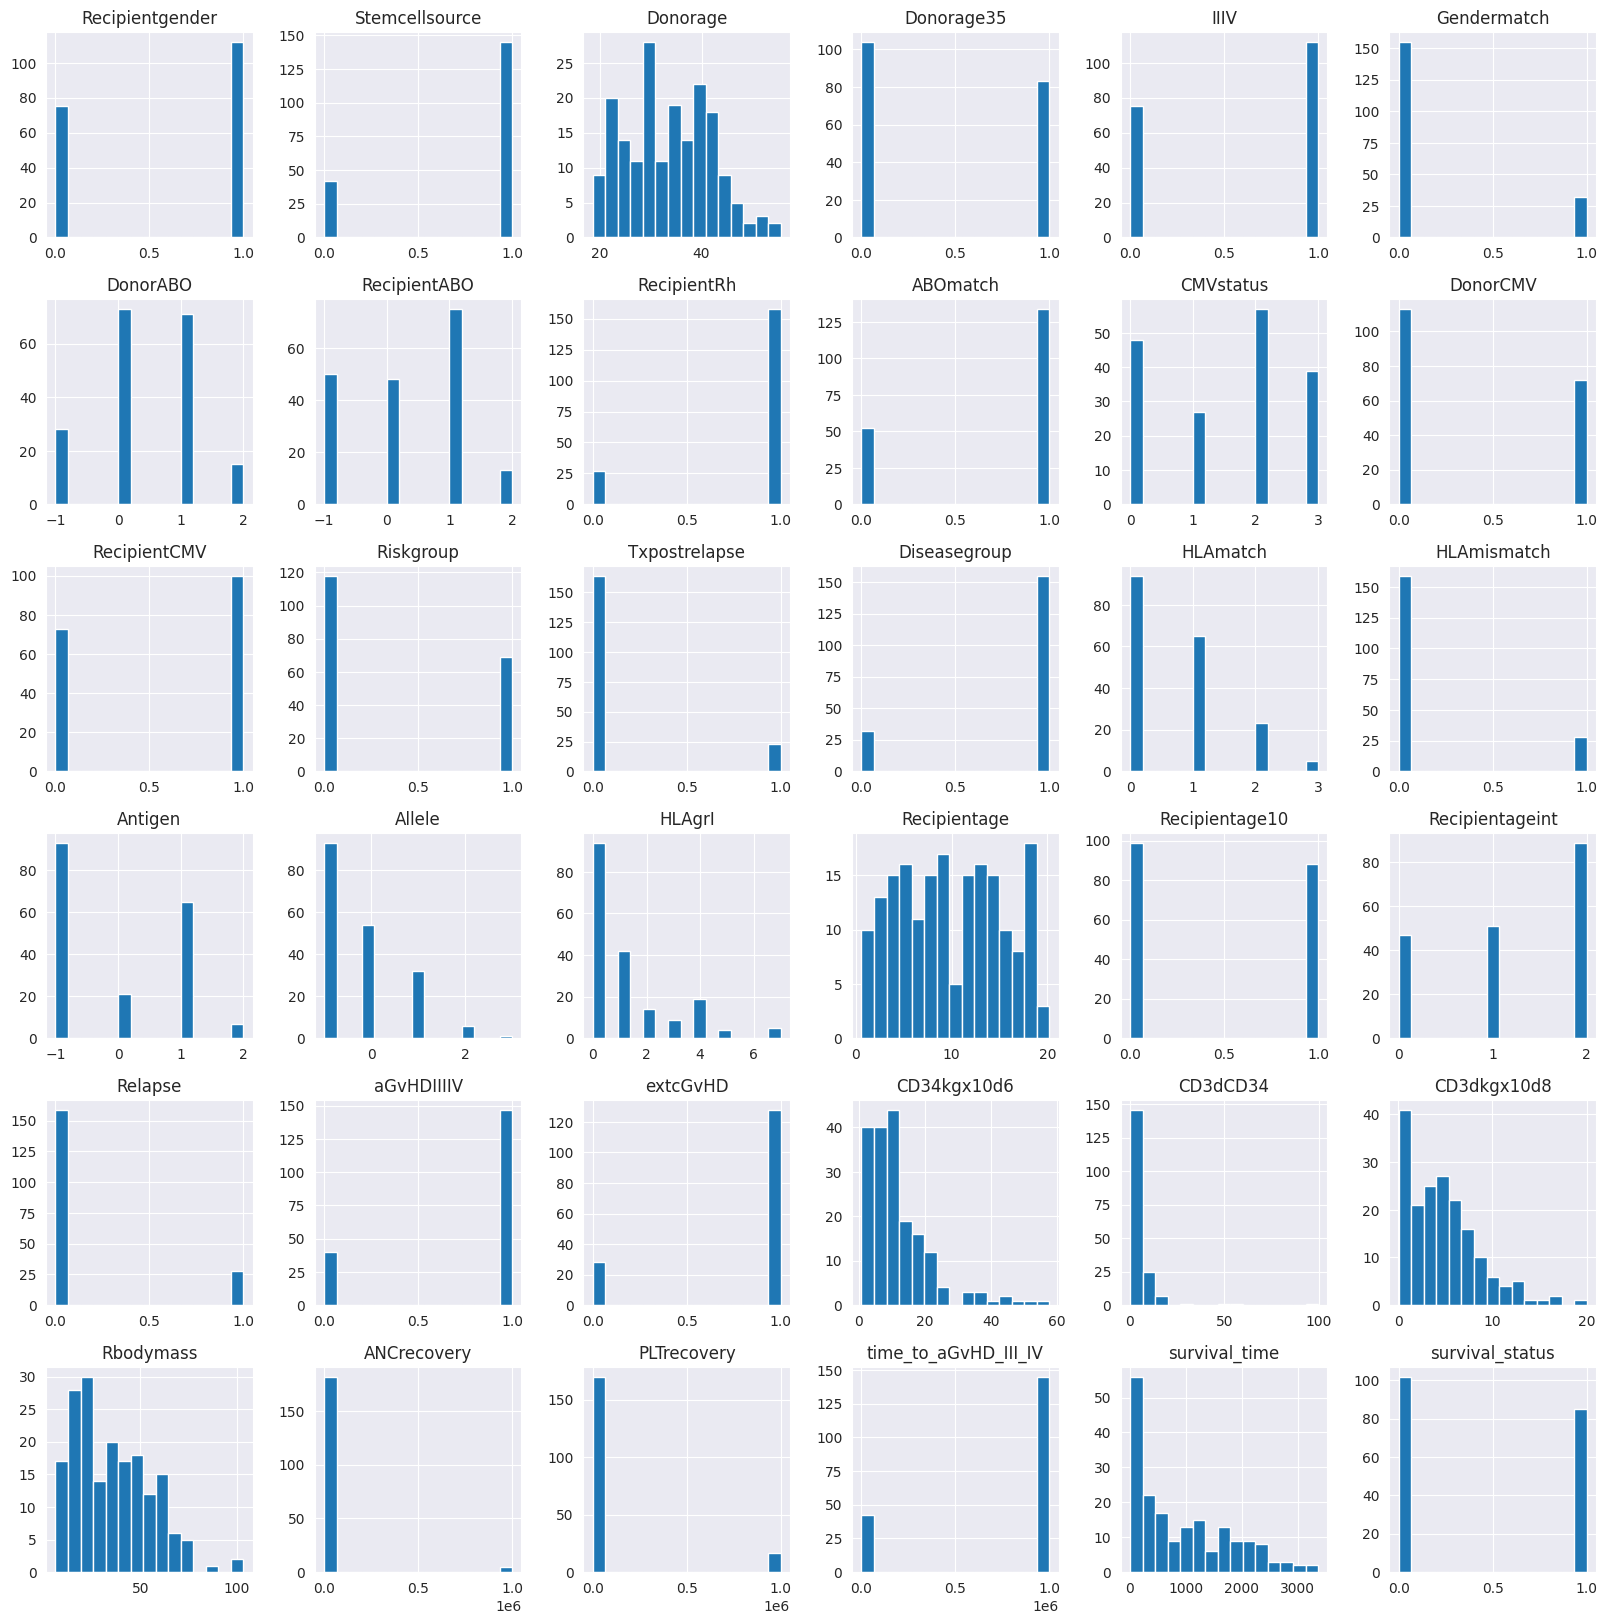

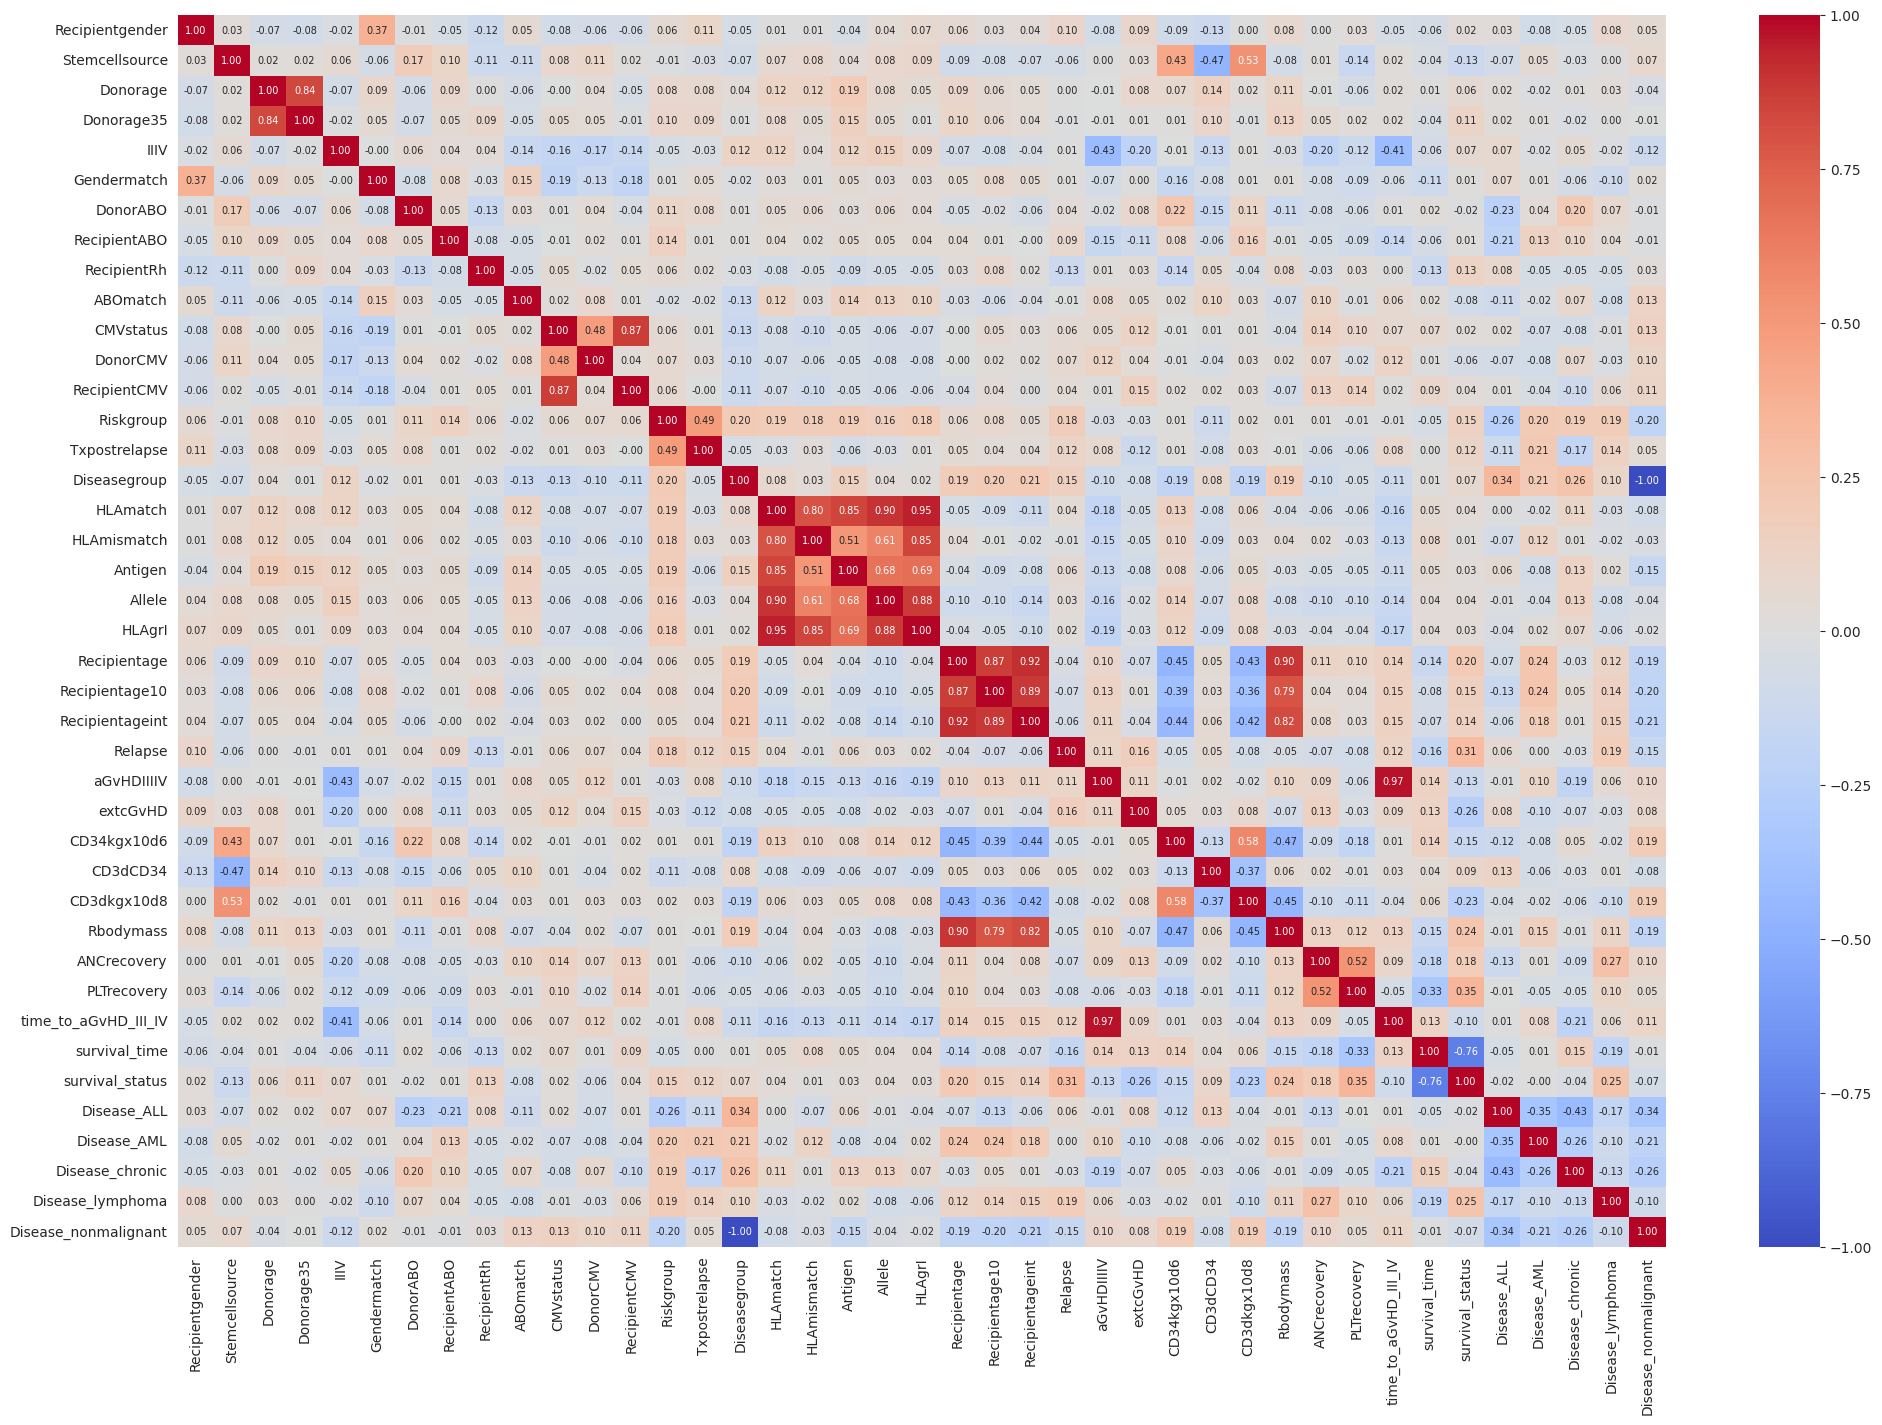

Variable: HLAgrI, Wrong values detected: 5
Variable: ANCrecovery, Wrong values detected: 5
Variable: PLTrecovery, Wrong values detected: 17
Variable: time_to_aGvHD_III_IV, Wrong values detected: 145
Confusion Matrix:


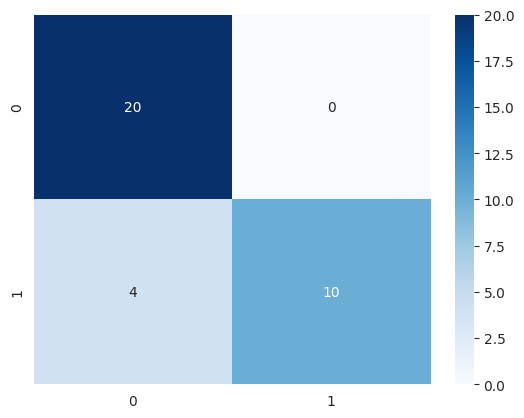

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       1.00      0.71      0.83        14

    accuracy                           0.88        34
   macro avg       0.92      0.86      0.87        34
weighted avg       0.90      0.88      0.88        34

Average Accuracy with CV: 0.9272727272727274


In [12]:
main(filepath=r'../data/raw/bone-marrow.csv')